# **Churn Prediction: Final Refined Version**
This notebook implements data preprocessing, thorough EDA, and model evaluation for churn prediction using Random Forest and XGBoost.

## **Step 1: Import Libraries**

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid')


## **Step 2: Load and Inspect Data**

In [2]:

# Load dataset
data = pd.read_csv('BankChurners.csv')

# Drop CLIENTNUM and Naive Bayes classifier columns
data.drop(columns=['CLIENTNUM', 
                   'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                   'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
          inplace=True)

# Overview
print("Data Overview:")
display(data.head())
print("Shape of data:", data.shape)
print("Null Values:")
print(data.isnull().sum())


Data Overview:


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Shape of data: (10127, 20)
Null Values:
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64


## **Step 3: Encode Categorical Columns and Clean Data**

In [3]:

# Encode target variable and binary features
data['Attrition_Flag'] = data['Attrition_Flag'].replace({'Attrited Customer': 1, 'Existing Customer': 0})
data['Gender'] = data['Gender'].replace({'F': 1, 'M': 0})

# One-hot encode categorical features
categorical_cols = ['Education_Level', 'Income_Category', 'Marital_Status', 'Card_Category']
for col in categorical_cols:
    if 'Unknown' in data[col].unique():
        data = pd.concat([data, pd.get_dummies(data[col], prefix=col).drop(columns='{}_Unknown'.format(col))], axis=1)
    else:
        data = pd.concat([data, pd.get_dummies(data[col], prefix=col)], axis=1)

# Drop original categorical columns
data.drop(columns=categorical_cols, inplace=True)

print("Cleaned Data:")
display(data.head())
print("Updated Shape:", data.shape)


Cleaned Data:


C:\Users\Becode-son\AppData\Local\Temp\ipykernel_7540\2551121044.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Attrition_Flag'] = data['Attrition_Flag'].replace({'Attrited Customer': 1, 'Existing Customer': 0})
C:\Users\Becode-son\AppData\Local\Temp\ipykernel_7540\2551121044.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Gender'] = data['Gender'].replace({'F': 1, 'M': 0})


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,...,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0,45,0,3,39,5,1,3,12691.0,777,...,True,False,False,False,True,False,True,False,False,False
1,0,49,1,5,44,6,1,2,8256.0,864,...,False,False,True,False,False,True,True,False,False,False
2,0,51,0,3,36,4,1,0,3418.0,0,...,False,True,False,False,True,False,True,False,False,False
3,0,40,1,4,34,3,4,1,3313.0,2517,...,False,False,True,False,False,False,True,False,False,False
4,0,40,0,3,21,5,1,0,4716.0,0,...,True,False,False,False,True,False,True,False,False,False


Updated Shape: (10127, 34)


## **Step 4: Exploratory Data Analysis**

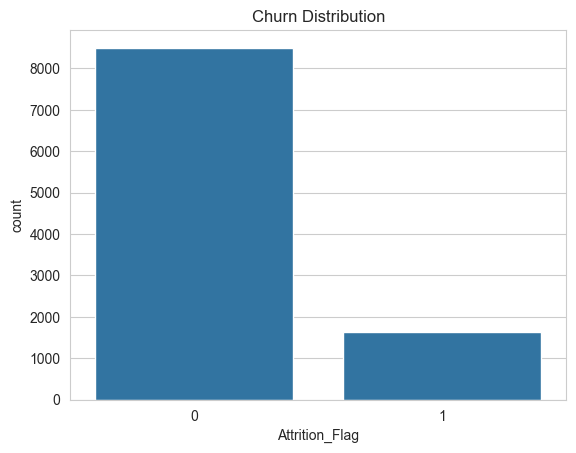

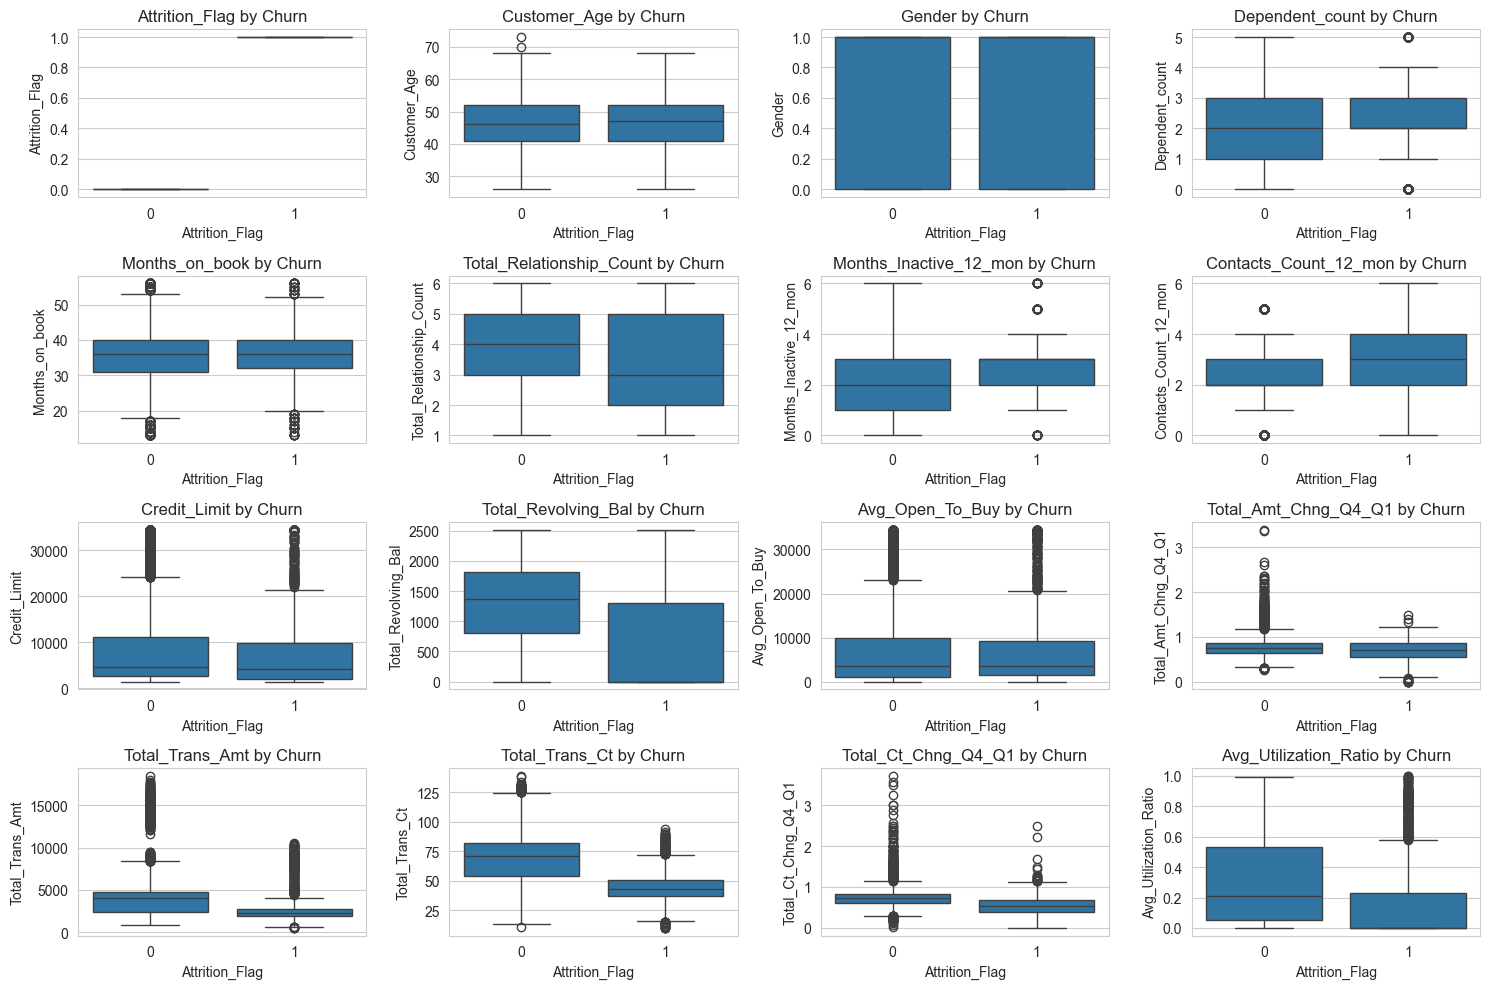

In [4]:

# Visualize class imbalance
sns.countplot(x='Attrition_Flag', data=data)
plt.title("Churn Distribution")
plt.show()

# Boxplots for numerical features to identify patterns
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=data[col], x=data['Attrition_Flag'])
    plt.title(f"{col} by Churn")
plt.tight_layout()
plt.show()


## **Step 5: Train-Test Split and Class Balancing with SMOTE**

In [5]:

# Split data
X = data.drop(columns=['Attrition_Flag'])
y = data['Attrition_Flag']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# SMOTE for imbalance handling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Class Distribution After SMOTE:")
print(y_train_res.value_counts())


Class Distribution After SMOTE:
Attrition_Flag
0    5949
1    5949
Name: count, dtype: int64


## **Step 6: Random Forest Model**

In [6]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_res, y_train_res)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Metrics:
Accuracy: 0.94
Precision: 0.80
Recall: 0.86
F1 Score: 0.83
Confusion Matrix:
[[2443  108]
 [  66  422]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2551
           1       0.80      0.86      0.83       488

    accuracy                           0.94      3039
   macro avg       0.88      0.91      0.90      3039
weighted avg       0.95      0.94      0.94      3039



## **Step 7: XGBoost Model**

In [7]:

xgb_model = XGBClassifier(scale_pos_weight=6, n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_res, y_train_res)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.2f}")
print("Classification Report:", classification_report(y_test, y_pred_xgb))


XGBoost Metrics:
Accuracy: 0.96
Precision: 0.85
Recall: 0.94
F1 Score: 0.89
Classification Report:               precision    recall  f1-score   support

           0       0.99      0.97      0.98      2551
           1       0.85      0.94      0.89       488

    accuracy                           0.96      3039
   macro avg       0.92      0.95      0.93      3039
weighted avg       0.97      0.96      0.96      3039



## **Step 8: Feature Importance**

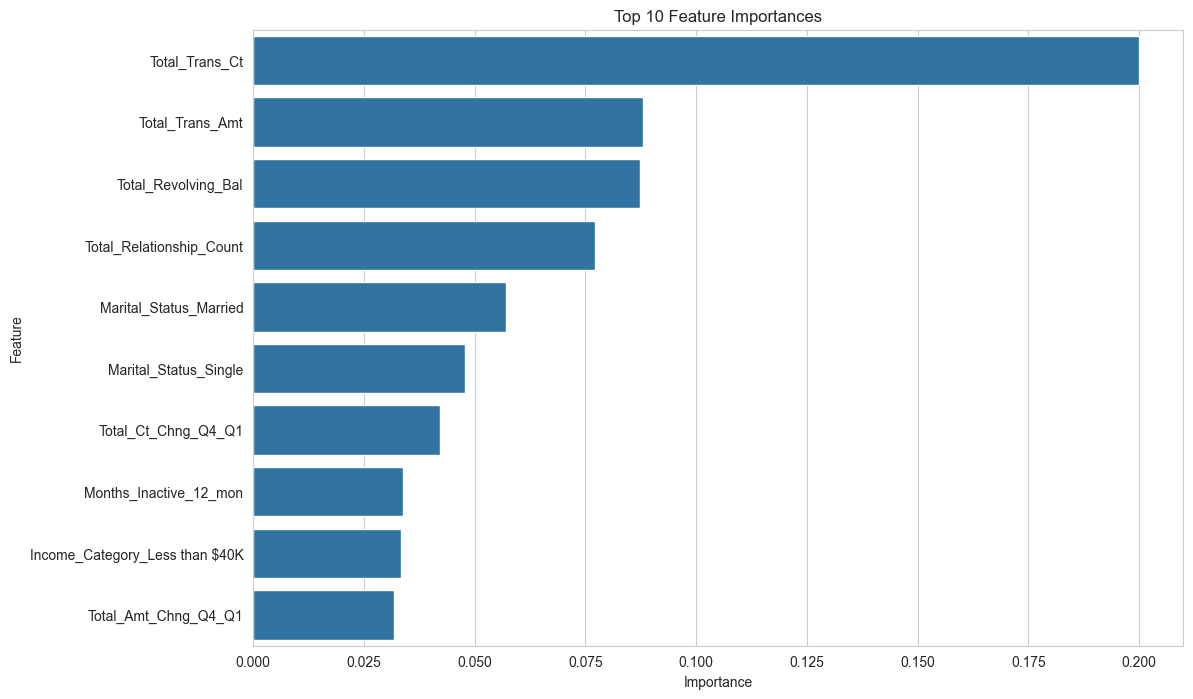

In [8]:

importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title("Top 10 Feature Importances")
plt.show()


## **Step 9: Feature Redundancy Test**
In this section, we evaluate whether `Total_Trans_Amt` can be safely dropped without significantly impacting the model performance. This is done by training and comparing the XGBoost model with and without the feature.

In [9]:

# Redefine features and target variable to avoid earlier modifications
X = data.drop(columns=['Attrition_Flag'])  # All features
y = data['Attrition_Flag']                # Target variable

# Section: Evaluating Redundant Features (Total_Trans_Ct vs Total_Trans_Amt)

# 1. Train model with both features
X_full = X.copy()  # Original features
y_full = y.copy()

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.3, random_state=42, stratify=y_full)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res_full, y_train_res_full = smote.fit_resample(X_train_full, y_train_full)

# Train XGBoost with both features
xgb_full = XGBClassifier(scale_pos_weight=6, n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
xgb_full.fit(X_train_res_full, y_train_res_full)
y_pred_full = xgb_full.predict(X_test_full)

# Evaluate
print("Model Performance with Both Features:")
print(f"Accuracy: {accuracy_score(y_test_full, y_pred_full):.2f}")
print(f"F1-Score: {f1_score(y_test_full, y_pred_full):.2f}")

# 2. Train model without Total_Trans_Amt
X_reduced = X.drop(columns=['Total_Trans_Amt'])  # Drop redundant feature

X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_reduced, y_full, test_size=0.3, random_state=42, stratify=y_full)

# Handle class imbalance
X_train_res_red, y_train_res_red = smote.fit_resample(X_train_red, y_train_red)

# Train XGBoost without Total_Trans_Amt
xgb_red = XGBClassifier(scale_pos_weight=6, n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
xgb_red.fit(X_train_res_red, y_train_res_red)
y_pred_red = xgb_red.predict(X_test_red)

# Evaluate
print("\nModel Performance Without Total_Trans_Amt:")
print(f"Accuracy: {accuracy_score(y_test_red, y_pred_red):.2f}")
print(f"F1-Score: {f1_score(y_test_red, y_pred_red):.2f}")

# 3. Compare results
print("\nComparison of Model Performance:")
print(f"Accuracy Difference: {accuracy_score(y_test_full, y_pred_full) - accuracy_score(y_test_red, y_pred_red):.4f}")
print(f"F1-Score Difference: {f1_score(y_test_full, y_pred_full) - f1_score(y_test_red, y_pred_red):.4f}")


Model Performance with Both Features:
Accuracy: 0.96
F1-Score: 0.89

Model Performance Without Total_Trans_Amt:
Accuracy: 0.90
F1-Score: 0.74

Comparison of Model Performance:
Accuracy Difference: 0.0605
F1-Score Difference: 0.1475
